In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
year = 3.1536e7               #Seconds in a year
M_sun = 1.9891e30             #Mass of sun in kg
M_Ch = 1.435 * M_sun          #Chandra Mass in kg
G = 6.6743e-11                #gravitational constant in m^3/kg/s^2
c = 299792458                 #speed in m/s
D = 3.086e22                  #Distance in meters (1 Mpc)
m1 = 0.5 * M_sun              #Mass of WD1 in kg
m2 = 0.5 * M_sun              #Mass of WD2 in kg
mu = (m1 * m2)/(m1 + m2)      #Reduced Mass of system in kg
M = m1 + m2                   #Total mass of system in kg
radius = ((7.8e8*((m1/M_Ch)**(-1/3))*((1-((m1/M_Ch)**(4/3)))**(1/2)))/100)              #Radius of the stars (m) 
fres = 1 / (5 * year)         #Frequency resolution 

# Define the range of values for the x (e) and y (nu) axes
min_e, max_e = 0, 0.98  # Example range for e
min_nu, max_nu = 0.0001, 0.0225  # Example range for nu
num_points = 100  # Number of points in each axis

In [3]:
# Create the grid of initial conditions
e_values = np.linspace(min_e, max_e, num_points)
log_nu_values = np.linspace(np.log10(min_nu), np.log10(max_nu), num_points)
e_grid, log_nu_grid = np.meshgrid(e_values, log_nu_values)

In [4]:
#Define our differential equations
def dnudt(e, nu):
    dnudt = (96/(10*np.pi))*(((c**6)*mu)/((M**3)*(G**2)))*((2*np.pi*(G*M/(c**3)*nu))**(11/3))*((1-(e**2))**(-9/2))*((1+((73/24)*(e**2))+((37/96)*(e**4)))*(1-(e**2)))
    return dnudt

def dedt(e, nu):
    dedt = -1*(e/15)*(((c**3)*mu)/((M**2)*G))*((1-(e**2))**(-7/2))*((2*np.pi*(G*M/(c**3)*nu))**(8/3))*((304+(121*(e**2)))*(1-(e**2)))
    return dedt

In [5]:
def calculate_t_char(e0, nu0):
    t_char = nu0 / dnudt(e0, nu0)
    return t_char

In [6]:
#Some useful constants
t_M = (G * M)/(c**3)         #Important value
f_res = 1/(5 * year)         #Frequency resolution given some observing period

In [15]:
#Define our coupled differential equations to solve
#Must declare t_char as an initial condition with a zero derivative or else solve_ivp gets very mad
def coupled_odes(t, y):
    A, e, t_char = y
    
    dAdt  = (96/(10*np.pi))*((t_char/t_M)*(mu/M))*((2*np.pi*A)**(11/3))*((1-(e**2))**(-9/2))*((1+((73/24)*(e**2))+((37/96)*(e**4)))*(1-(e**2)))
    
    dedt = -1*(e/15)*((t_char/t_M)*(mu/M))*((1-(e**2))**(-7/2))*((2*np.pi*A)**(8/3))*((304+(121*(e**2)))*(1-(e**2)))
    
    dt_chardt = 0
    
    return [dAdt, dedt, dt_chardt]

# Perform the integration using a loop over the grid of initial conditions
dnu_fres_values = np.zeros_like(e_grid)

for i in range(num_points):
    for j in range(num_points):
        e0 = e_grid[i, j]
        log_nu0 = log_nu_grid[i, j]
        nu0 = 10**log_nu0
        
        # Calculate the constant for the current initial condition
        t_char = calculate_t_char(e0, nu0)
        #A modified version of nu
        A0 = t_M * nu0
        #Initial Time
        t0 = 0
        #Final Time
        tf = (5 * year)/t_char
        #Define a time frame
        t_span = [t0, tf]
        times = np.linspace(t0,tf,10000)
        
        # Solve the differential equations for each initial condition
        sol = solve_ivp(coupled_odes, t_span, [A0, e0, t_char])
        
        # Extract the solution and calculate delta_nu as the difference between the final and initial nu values
        e_solution = sol.y[1]
        nu_solution = sol.y[0] / t_M
        
        a = np.cbrt(((1/nu_solution[-1])**2)*((G*M)/(4*(np.pi**2))))
        separation = a * (1 - e_solution[-1])
        
        if separation <= 2 * radius:
            nu_solution[-1] = nu0
        
        delta_nu = nu_solution[-1] - nu0
        
        if delta_nu <= fres:
            nu_solution[-1] = nu0
            delta_nu = nu_solution[-1] - nu0
        
        dnu_fres = delta_nu / fres
        dnu_fres_values[i, j] = np.log(dnu_fres)

/tmp/ipykernel_11159/4040959282.py:55: RuntimeWarning: divide by zero encountered in log
  dnu_fres_values[i, j] = np.log(dnu_fres)
/tmp/ipykernel_11159/4040959282.py:6: RuntimeWarning: invalid value encountered in scalar power
  dAdt  = (96/(10*np.pi))*((t_char/t_M)*(mu/M))*((2*np.pi*A)**(11/3))*((1-(e**2))**(-9/2))*((1+((73/24)*(e**2))+((37/96)*(e**4)))*(1-(e**2)))
/tmp/ipykernel_11159/4040959282.py:8: RuntimeWarning: invalid value encountered in scalar power
  dedt = -1*(e/15)*((t_char/t_M)*(mu/M))*((1-(e**2))**(-7/2))*((2*np.pi*A)**(8/3))*((304+(121*(e**2)))*(1-(e**2)))


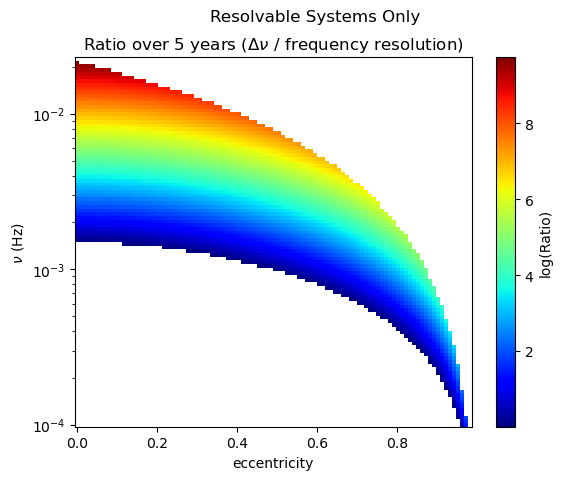

In [17]:
# Create a color plot of the delta_nu values
plt.pcolormesh(e_grid, 10**log_nu_grid, dnu_fres_values, cmap='jet')
plt.colorbar(label='log(Ratio)')
plt.xlabel('eccentricity')
plt.ylabel(r'$\nu$ (Hz)')
plt.yscale('log')
plt.suptitle('Resolvable Systems Only')
plt.title(r'Ratio over 5 years $(\Delta\nu$ / frequency resolution)')
plt.show()